<a href="https://colab.research.google.com/github/avdhoot001/Machine_learning/blob/main/reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

import numpy as np
from typing import Literal
import matplotlib.pyplot as plt
import PIL.Image as Image
from glob import glob

In [5]:

import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
from tqdm import tqdm, trange
from glob import glob
import os
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [12]:
!wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/stranger-sections-2/stranger-sections-2-train-data.zip #training data

--2024-05-20 12:38:38--  https://xeek-public-287031953319-eb80.s3.amazonaws.com/stranger-sections-2/stranger-sections-2-train-data.zip
Resolving xeek-public-287031953319-eb80.s3.amazonaws.com (xeek-public-287031953319-eb80.s3.amazonaws.com)... 16.182.39.17, 3.5.28.212, 52.216.50.105, ...
Connecting to xeek-public-287031953319-eb80.s3.amazonaws.com (xeek-public-287031953319-eb80.s3.amazonaws.com)|16.182.39.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26029613 (25M) [application/zip]
Saving to: ‘stranger-sections-2-train-data.zip’

stranger-sections-2 100%[===================>]  24.82M  51.8MB/s    in 0.5s    

2024-05-20 12:38:38 (51.8 MB/s) - ‘stranger-sections-2-train-data.zip’ saved [26029613/26029613]



In [13]:
!pip install patool
import patoolib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 3.3 MB/s eta 0:00:00


In [14]:
patoolib.extract_archive('/content/stranger-sections-2-train-data.zip')

INFO patool: Extracting /content/stranger-sections-2-train-data.zip ...
INFO:patool:Extracting /content/stranger-sections-2-train-data.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_uzvb8v3f -- /content/stranger-sections-2-train-data.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_uzvb8v3f -- /content/stranger-sections-2-train-data.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/stranger-sections-2-train-data.zip extracted to `stranger-sections-2-train-data' (multiple files in root).
INFO:patool:... /content/stranger-sections-2-train-data.zip extracted to `stranger-sections-2-train-data' (multiple files in root).


'stranger-sections-2-train-data'

In [15]:
# https://youtu.be/XyX5HNuv-xE
# https://youtu.be/q-p8v1Bxvac
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model


In [16]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [ ]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=4 #Number of classes for segmentation

In [19]:
os.makedirs("image_patches", exist_ok=True)
images = sorted(glob.glob('/content/stranger-sections-2-train-data/image/*'))

start_no = 0
for image in tqdm(images):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)

    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 3])


    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,:]).astype('uint8')
        imname = 'im%03d.png'%(start_no + i)

        im = Image.fromarray(im.astype(np.uint8))
        im.save(os.path.join("/content/image_patches",imname))

    start_no = start_no + patches.shape[0]

100%|██████████| 87/87 [03:49<00:00,  2.63s/it]


In [20]:
os.makedirs("label_patches", exist_ok=True)
labels = sorted(glob.glob('/content/stranger-sections-2-train-data/label/*'))
start_no = 0
for image2 in tqdm(labels):
    array = np.load(image2)

    # Load the large image
    # large_image = tf.keras.preprocessing.image.load_img(image)
    # large_image = image
    # Convert the image to a tensor
    # large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    large_image = tf.convert_to_tensor(array)

# Check the type and shape of the tensor
    # print("Type of the tensor:", type(large_image))
    # print("Shape of the tensor:", large_image.shape)

    large_image = large_image[:,:,np.newaxis] # only keep one layer and add a new axis
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 1])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,0]).astype('uint8')
        imname =  'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(os.path.join("/content/label_patches",imname))

    start_no = start_no + patches.shape[0]


100%|██████████| 87/87 [00:17<00:00,  4.99it/s]


In [23]:
image = Image.open("/content/label_patches/im000.png")  # Replace "your_image.jpg" with the path to your JPG image
image_array = np.array(image)
image_array.shape

(256, 256)

In [ ]:
train_images = []
import glob

for directory_path in glob.glob("/content/image_patches"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

#Convert list to array for machine learning processing
train_images = np.array(train_images)

In [ ]:
train_images.shape

(5481, 256, 256)

In [ ]:
train_masks = []
for directory_path in glob.glob("/content/label_patches"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

#Convert list to array for machine learning processing
train_masks = np.array(train_masks)

In [ ]:
train_masks.shape


(5481, 256, 256)

In [ ]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

In [ ]:
train_masks_input = np.expand_dims(train_masks, axis=3)

In [ ]:
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)


In [ ]:

n_classes = 4
from keras.utils import to_categorical
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)


NameError: name 'train_masks_reshaped_encoded' is not defined

In [ ]:

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


In [9]:
def get_model():
    return multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [2]:
from google.colab import files
loading = files.upload()

Saving test(1).hdf5 to test(1).hdf5


In [10]:
model.load_weights("/content/test(1).hdf5")

In [ ]:
model.save('test.hdf5')

In [ ]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


18/18 [==============================] - 9s 142ms/step - loss: 0.0954 - accuracy: 0.9787
Accuracy is =  97.86624908447266 %


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

18/18 [==============================] - 1s 66ms/step


In [ ]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8608296


[[1.6777216e+07 2.9029000e+04 1.0851100e+05 6.8189000e+04]
 [5.2763000e+04 7.1690600e+05 1.0459000e+04 0.0000000e+00]
 [4.4123900e+05 1.1700000e+02 2.2797490e+06 5.0000000e+00]
 [5.7400000e+04 0.0000000e+00 0.0000000e+00 4.9594100e+05]]
IoU for class1 is:  0.9568201
IoU for class2 is:  0.8858631
IoU for class3 is:  0.8027059
IoU for class4 is:  0.79792935


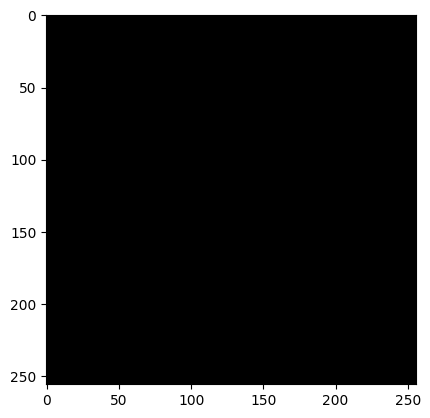

In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

1/1 [==============================] - 0s 47ms/step


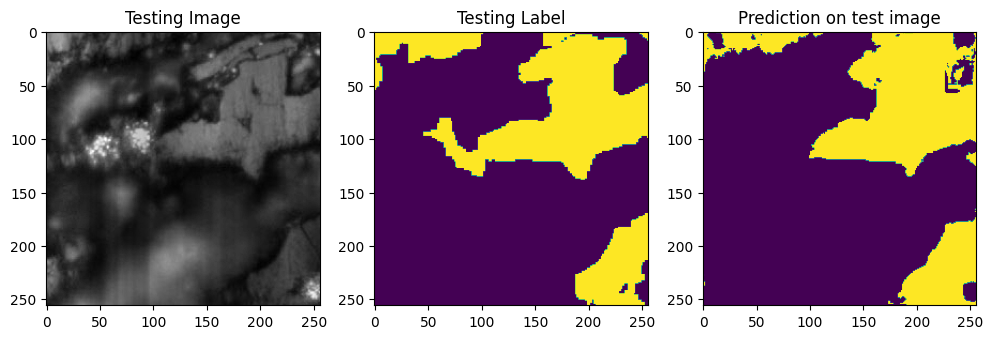

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
# test_img = X_test[test_img_number]
test_img = "/content/patches/patch_0.png"

# ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving stranger-sections-2-test-data(1).zip to stranger-sections-2-test-data(1).zip


In [ ]:
patoolib.extract_archive("/content/stranger-sections-2-test-data(1).zip")

INFO patool: Extracting /content/stranger-sections-2-test-data(1).zip ...
INFO:patool:Extracting /content/stranger-sections-2-test-data(1).zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_epmbp_rh -- /content/stranger-sections-2-test-data(1).zip
INFO:patool:running /usr/bin/7z x -o./Unpack_epmbp_rh -- /content/stranger-sections-2-test-data(1).zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/stranger-sections-2-test-data(1).zip extracted to `image'.
INFO:patool:... /content/stranger-sections-2-test-data(1).zip extracted to `image'.


'image'

In [ ]:
from PIL import Image
import numpy as np
import os

# Load the image
image = Image.open('/content/one_image/2fpvuk.JPG')  # Replace with your image path

# Convert image to NumPy array
image_array = np.array(image)

# Get dimensions of the image
img_height, img_width = image_array.shape[:2]

# Patch size
patch_height = 256
patch_width = 256

# Step size (amount of overlap)
step_size = 128  # 50% overlap

# Create a directory to save patches if it doesn't exist
os.makedirs('patches', exist_ok=True)

# Initialize list to store patches
patches = []

# Divide the image into patches with overlap
patch_index = 0
for i in range(0, img_height - patch_height + 1, step_size):
    for j in range(0, img_width - patch_width + 1, step_size):
        patch = image_array[i:i + patch_height, j:j + patch_width]
        patches.append(patch)
        # Convert the patch to a PIL image and save it
        patch_image = Image.fromarray(patch)
        patch_image.save(f'patches/patch_{patch_index}.png')
        patch_index += 1

# Handling remaining bottom part if not fully covered
if (img_height - patch_height) % step_size != 0:
    for j in range(0, img_width - patch_width + 1, step_size):
        patch = image_array[-patch_height:, j:j + patch_width]
        patches.append(patch)
        patch_image = Image.fromarray(patch)
        patch_image.save(f'patches/patch_{patch_index}.png')
        patch_index += 1

# Handling remaining right part if not fully covered
if (img_width - patch_width) % step_size != 0:
    for i in range(0, img_height - patch_height + 1, step_size):
        patch = image_array[i:i + patch_height, -patch_width:]
        patches.append(patch)
        patch_image = Image.fromarray(patch)
        patch_image.save(f'patches/patch_{patch_index}.png')
        patch_index += 1

# Handling bottom-right corner if not fully covered
if (img_height - patch_height) % step_size != 0 and (img_width - patch_width) % step_size != 0:
    patch = image_array[-patch_height:, -patch_width:]
    patches.append(patch)
    patch_image = Image.fromarray(patch)
    patch_image.save(f'patches/patch_{patch_index}.png')


In [ ]:

images = sorted(glob.glob('/content/one_image/*'))

start_no = 0
for image in tqdm(images):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)

    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 16, 16, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 3])


    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,:]).astype('uint8')
        imname = 'im%03d.png'%(start_no + i)

        im = Image.fromarray(im.astype(np.uint8))
        im.save(os.path.join("/content/patches",imname))

    start_no = start_no + patches.shape[0]

  0%|          | 0/1 [01:51<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
test_images = []

for directory_path in glob.glob("/content/patches"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        test_images.append(img)

#Convert list to array for machine learning processing
test_images = np.array(test_images)

In [ ]:
test_images.shape

(70, 256, 256)

array([[126, 119, 117, ..., 123, 126, 132],
       [128, 120, 118, ..., 121, 128, 136],
       [129, 124, 121, ..., 119, 127, 139],
       ...,
       [ 69,  68,  71, ..., 128, 128, 129],
       [ 68,  66,  66, ..., 129, 129, 130],
       [ 63,  64,  63, ..., 129, 130, 131]], dtype=uint8)
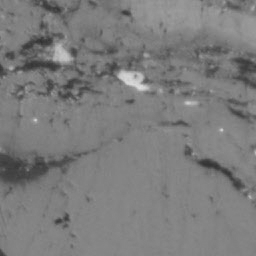

In [ ]:
test_images[0]

In [ ]:
import numpy as np

# Patch size
patch_height = 256
patch_width = 256

# Number of patches along height and width
patches_along_height = 7
patches_along_width = 10

# Determine the original image size
original_height = patches_along_height * patch_height
original_width = patches_along_width * patch_width

# Initialize the empty image
reconstructed_image = np.zeros((original_height, original_width), dtype=np.float32)


In [ ]:
# Assuming patches is your numpy array of shape (63, 256, 256)
patches = test_images# Replace this with your actual patches array

# Place each patch in its corresponding location in the reconstructed image
patch_index = 0
for i in range(patches_along_height):
    for j in range(patches_along_width):
        start_row = i * patch_height
        end_row = start_row + patch_height
        start_col = j * patch_width
        end_col = start_col + patch_width
        reconstructed_image[start_row:end_row, start_col:end_col] = patches[patch_index]
        patch_index += 1


In [ ]:
reconstructed_image.shape

(1792, 2560)

In [ ]:
#convert this to png and see how does it look


In [ ]:
import numpy as np

# Patch size
patch_height = 256
patch_width = 256

# Overlap size (adjust as necessary)
overlap_height = 128
overlap_width = 128

# Effective step size for moving the patch
step_height = patch_height - overlap_height
step_width = patch_width - overlap_width

# Number of patches along height and width
patches_along_height = 7
patches_along_width = 10

# Determine the original image size
original_height = step_height * (patches_along_height - 1) + patch_height
original_width = step_width * (patches_along_width - 1) + patch_width

# Initialize the empty image and a weight array
reconstructed_image = np.zeros((original_height, original_width), dtype=np.float32)
weight_array = np.zeros((original_height, original_width), dtype=np.float32)


In [ ]:
# Assuming patches is your numpy array of shape (63, 256, 256)
patches = test_images  # Replace this with your actual patches array

# Place each patch in its corresponding location in the reconstructed image
patch_index = 0
for i in range(patches_along_height):
    for j in range(patches_along_width):
        start_row = i * step_height
        end_row = start_row + patch_height
        start_col = j * step_width
        end_col = start_col + patch_width

        # Add the patch values to the corresponding region in the reconstructed image
        reconstructed_image[start_row:end_row, start_col:end_col] += patches[patch_index]

        # Increment the weight array for the overlapping regions
        weight_array[start_row:end_row, start_col:end_col] += 1

        patch_index += 1

# Avoid division by zero in non-overlapping regions
weight_array[weight_array == 0] = 1

# Average the overlapping regions
reconstructed_image /= weight_array


In [ ]:
reconstructed_image.shape

(1024, 1408)

In [ ]:
import numpy as np
from PIL import Image

# Create a 2D NumPy array (for example purposes)
# array = np.random.rand(256, 256) * 255  # Creating a 256x256 array with values from 0 to 255
# array = array.astype(np.uint8)  # Convert the array to unsigned 8-bit (0-255)

# Convert the array to a PIL Image
image = Image.fromarray(reconstructed_image)

# Convert to grayscale
image = image.convert('L')

# Save the image as a PNG file
image.save('grayscale_image1.png')

# To display the image in a Jupyter notebook or Google Colab
image.show()


In [ ]:
import shutil
shutil.rmtree("/content/patches")

In [6]:
from PIL import Image
import numpy as np
import os

# Load the image
image = Image.open('/content/2fpvuk.JPG')  # Replace with your image path
image_array = np.array(image)

# Image dimensions
img_height, img_width = image_array.shape[:2]

# Patch size
patch_height = 256
patch_width = 256

# Stride for overlap (you can adjust this to control overlap)
stride = 128

# Create a directory to save patches if it doesn't exist
os.makedirs('patches', exist_ok=True)

# Initialize list to store patches
patches = []

# Divide the image into patches with overlap
patch_index = 0
for i in range(0, img_height - patch_height + 1, stride):
    for j in range(0, img_width - patch_width + 1, stride):
        patch = image_array[i:i + patch_height, j:j + patch_width]
        patches.append(patch)
        # Convert the patch to a PIL image and save it
        patch_image = Image.fromarray(patch)
        patch_image.save(f'patches/patch_{patch_index}.png')
        patch_index += 1

# Handling the rightmost patches if they exist
if (img_width - patch_width) % stride != 0:
    for i in range(0, img_height - patch_height + 1, stride):
        patch = image_array[i:i + patch_height, -patch_width:]
        patches.append(patch)
        patch_image = Image.fromarray(patch)
        patch_image.save(f'patches/patch_{patch_index}.png')
        patch_index += 1

# Handling the bottom patches if they exist
if (img_height - patch_height) % stride != 0:
    for j in range(0, img_width - patch_width + 1, stride):
        patch = image_array[-patch_height:, j:j + patch_width]
        patches.append(patch)
        patch_image = Image.fromarray(patch)
        patch_image.save(f'patches/patch_{patch_index}.png')
        patch_index += 1

# Handling bottom-right corner patch if it exists
if (img_height - patch_height) % stride != 0 and (img_width - patch_width) % stride != 0:
    patch = image_array[-patch_height:, -patch_width:]
    patches.append(patch)
    patch_image = Image.fromarray(patch)
    patch_image.save(f'patches/patch_{patch_index}.png')



In [7]:
# Reconstruct the image from patches

reconstructed_image = np.zeros((img_height, img_width, 3), dtype=np.float32)
weight_array = np.zeros((img_height, img_width, 3), dtype=np.float32)

patch_index = 0
for i in range(0, img_height - patch_height + 1, stride):
    for j in range(0, img_width - patch_width + 1, stride):
        patch = patches[patch_index]
        reconstructed_image[i:i + patch_height, j:j + patch_width] += patch
        weight_array[i:i + patch_height, j:j + patch_width] += 1
        patch_index += 1

# Handling the rightmost patches if they exist
if (img_width - patch_width) % stride != 0:
    for i in range(0, img_height - patch_height + 1, stride):
        patch = patches[patch_index]
        reconstructed_image[i:i + patch_height, -patch_width:] += patch
        weight_array[i:i + patch_height, -patch_width:] += 1
        patch_index += 1

# Handling the bottom patches if they exist
if (img_height - patch_height) % stride != 0:
    for j in range(0, img_width - patch_width + 1, stride):
        patch = patches[patch_index]
        reconstructed_image[-patch_height:, j:j + patch_width] += patch
        weight_array[-patch_height:, j:j + patch_width] += 1
        patch_index += 1

# Handling bottom-right corner patch if it exists
if (img_height - patch_height) % stride != 0 and (img_width - patch_width) % stride != 0:
    patch = patches[patch_index]
    reconstructed_image[-patch_height:, -patch_width:] += patch
    weight_array[-patch_height:, -patch_width:] += 1

# Avoid division by zero
weight_array[weight_array == 0] = 1

# Average the overlapping regions
reconstructed_image /= weight_array

# Convert the reconstructed image to uint8
reconstructed_image = reconstructed_image.astype(np.uint8)

# Save or display the reconstructed image
reconstructed_img = Image.fromarray(reconstructed_image)
reconstructed_img.save('reconstructed_image.png')
reconstructed_img.show()


Shape of the image array: (256, 256, 3)
Data type of the image array: uint8


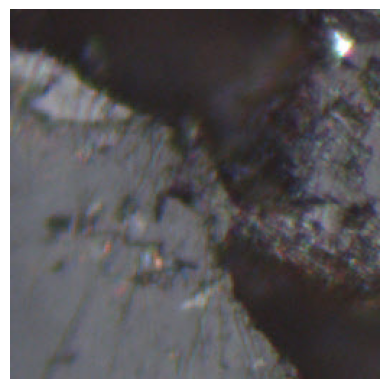

In [11]:


# Load the image
image_path = '/content/patches/patch_0.png'  # Replace with your image path
image = Image.open(image_path)

# Convert the image to a NumPy array
image_array = np.array(image)

# Print the shape and type of the array to verify
print("Shape of the image array:", image_array.shape)
print("Data type of the image array:", image_array.dtype)

# Optionally, display the image using matplotlib (if you want to visualize it)
import matplotlib.pyplot as plt

plt.imshow(image_array)
plt.axis('off')  # Hide axes
plt.show()


In [25]:
image = Image.open("/content/patches/patch_0.png")  # Replace "your_image.jpg" with the path to your JPG image
image_array = np.array(image)
image_array.shape




(256, 256, 3)

In [26]:
image = Image.open("/content/image_patches/im000.png")  # Replace "your_image.jpg" with the path to your JPG image
image_array = np.array(image)
image_array.shape

(256, 256, 3)